### Задача

Предоставлены данные сервиса по продажам билетов с июня 2017 по конец мая 2018 года. Необходимо оптимизировать маркетинговые затраты, изучив: как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда клиент окупается.

### Импорт библиотек и настройки

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

### Оглавление

[1. Открытие и подготовка данных](#1.-Открытие-и-подготовка-данных)  
[2. Построение отчётов и расчет метрик](#2.-Построение-отчётов-и-расчет-метрик)  
&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Продукт](#2.1-Продукт)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.1 Сколько людей пользуются в день, неделю, месяц?](#2.1.1-Сколько-людей-пользуются-в-день,-неделю,-месяц?)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.2 Сколько сессий в день?](#2.1.2-Сколько-сессий-в-день?)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.3 Сколько длится одна сессия?](#2.1.3-Сколько-длится-одна-сессия?)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.4 Как часто люди возвращаются?](#2.1.4-Как-часто-люди-возвращаются?)  
&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Продажи](#2.2-Продажи)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.1 Когда люди начинают покупать?](#2.2.1-Когда-люди-начинают-покупать?)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.2 Сколько раз покупают за период?](#2.2.2-Сколько-раз-покупают-за-период?)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.3 Какой средний чек?](#2.2.3-Какой-средний-чек?)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.4 Сколько денег приносят?](#2.2.4-Сколько-денег-приносят?)  
&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Маркетинг](#2.3-Маркетинг)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.1 Сколько денег потратили? Всего / на каждый источник / по времени](#2.3.1-Сколько-денег-потратили?-Всего-/-на-каждый-источник-/-по-времени)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.2 Сколько стоило привлечение одного покупателя из каждого источника?](#2.3.2-Сколько-стоило-привлечение-одного-покупателя-из-каждого-источника?)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.3 На сколько окупились расходы?](#2.3.3-На-сколько-окупились-расходы?)  
[3. Общий вывод](#3.-Общий-вывод)

### 1. Открытие и подготовка данных

In [2]:
visits = pd.read_csv('../datasets/visits_log.csv')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [3]:
orders = pd.read_csv('../datasets/orders_log.csv')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [4]:
costs = pd.read_csv('../datasets/costs.csv')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Пропущенных значений нет, колонки с датой имеют тип `object`, в названиях колонок 2 датафреймов используется разный регистр и пробелы.

Приведем названия колонок к единообразию.

In [5]:
visits.columns = visits.columns.str.replace(' ', '_')
orders.columns = orders.columns.str.replace(' ', '_')
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()

Исправим тип данных в колонках с датами.

In [6]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d %H:%M:%S')

Добавим дополнительные колонки.

In [7]:
visits['start_year'] = visits['start_ts'].dt.year
visits['start_month'] = visits['start_ts'].dt.month
visits['start_week'] = visits['start_ts'].dt.week
visits['start_date'] = visits['start_ts'].dt.date

In [8]:
visits.head(5)

,device,end_ts,source_id,start_ts,uid,start_year,start_month,start_week,start_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


In [9]:
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   device       359400 non-null  object        
 1   end_ts       359400 non-null  datetime64[ns]
 2   source_id    359400 non-null  int64         
 3   start_ts     359400 non-null  datetime64[ns]
 4   uid          359400 non-null  uint64        
 5   start_year   359400 non-null  int64         
 6   start_month  359400 non-null  int64         
 7   start_week   359400 non-null  int64         
 8   start_date   359400 non-null  object        
dtypes: datetime64[ns](2), int64(4), object(2), uint64(1)
memory usage: 24.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50

### 2. Построение отчётов и расчет метрик

#### 2.1 Продукт

#### 2.1.1 Сколько людей пользуются в день, неделю, месяц?

Посчитаем количество уникальных пользователей.

День (DAU).

In [10]:
dau_total = round(visits.groupby('start_date')['uid'].nunique().mean())
print(dau_total,'людей пользуются в день в среднем')

908 людей пользуются в день в среднем


По устройствам.

In [11]:
dau_total_d = visits.pivot_table(index='start_date', columns='device', values='uid', aggfunc='nunique').mean(axis=0).round()
dau_total_d

device
desktop    659.0
touch      253.0
dtype: float64

Неделя (WAU).

In [12]:
wau_total = round(visits.groupby(['start_year','start_week'])['uid'].nunique().mean())
print(wau_total,'людей пользуются в неделю в среднем')

5716 людей пользуются в неделю в среднем


По устройствам.

In [13]:
wau_total_d = visits.pivot_table(
    index=['start_year','start_week'], columns='device', values='uid', aggfunc='nunique'
).mean(axis=0).round()
wau_total_d

device
desktop    4130.0
touch      1635.0
dtype: float64

Месяц (MAU).

In [14]:
mau_total = round(visits.groupby(['start_year','start_month'])['uid'].nunique().mean())
print(mau_total,'людей пользуются в месяц в среднем')

23228 людей пользуются в месяц в среднем


Text(0.5, 1.0, 'Количество уникальных пользователей в месяц')

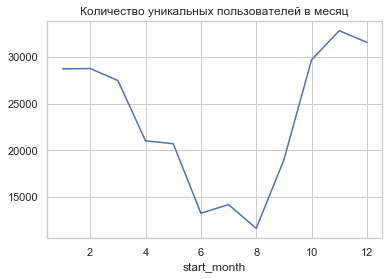

In [15]:
visits.groupby(['start_month'])['uid'].nunique().plot().set_title('Количество уникальных пользователей в месяц')

С августа по ноябрь количество пользователей значительно выросло, далее постепенно начало снижаться.

По устройствам.

In [16]:
mau_total_d = visits.pivot_table(
    index=['start_month'], columns='device', values='uid', aggfunc='nunique'
).reset_index()
mau_total_d.mean(axis=0).round()

device
start_month        6.0
desktop        16725.0
touch           6826.0
dtype: float64

Text(0.5, 1.0, 'Количество уникальных пользователей в месяц')

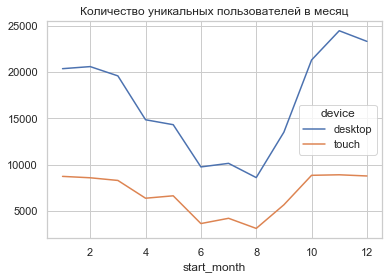

In [17]:
mau_total_d.plot(x='start_month').set_title('Количество уникальных пользователей в месяц')

Линия touch более сглаженная. Тенденции явно отслеживаются на desktop и отражают общую динамику.

#### 2.1.2 Сколько сессий в день?

In [18]:
count_ts_day = round(visits.groupby('start_date')['uid'].count().mean())
print(count_ts_day,'сессий в день в среднем')

987 сессий в день в среднем


In [19]:
count_ts_day_for_user = count_ts_day / dau_total
print(round(count_ts_day_for_user,2),'сессий в день в среднем на одного пользователя')

1.09 сессий в день в среднем на одного пользователя


По устройствам.

In [20]:
count_ts_day_d = visits.pivot_table(index='start_date', columns='device', values='uid', aggfunc='count').mean(axis=0).round()
count_ts_day_d

device
desktop    721.0
touch      267.0
dtype: float64

In [21]:
count_ts_day_for_user_d = count_ts_day_d / dau_total_d
count_ts_day_for_user_d

device
desktop    1.094082
touch      1.055336
dtype: float64

С desktop устройства сессий в день в 2,7 раза больше, чем с touch. В среднем в день пользователь заходит 1 раз на любом устройстве.

#### 2.1.3 Сколько длится одна сессия?

In [22]:
visits['delta_ts'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [23]:
visits['delta_ts'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: delta_ts, dtype: float64

In [24]:
print(visits['delta_ts'].mode()[0], ' - модальное значение')

60  - модальное значение


Посмотрим распределение длительности сессий

Text(0.5, 0, 'delta_ts')

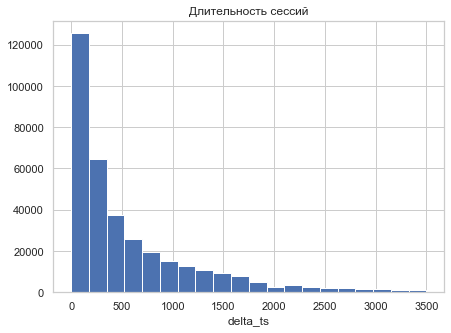

In [25]:
plt.figure(figsize=(7,5))
visits['delta_ts'].hist(bins=20, range=(0, 3500)).set_title('Длительность сессий')
plt.xlabel('delta_ts')

Распределение не похоже на нормальное, большая часть значений находится около нуля. Моду не будем использовать как среднюю длительность сессии, так как всего 25% выборки включают значения до 120 сек. Мода будет отражать малую часть выборки.  
На среднее значение влияют аномально высокие значения, поэтому использовать его тоже не корректно. За среднюю длительность сессий примем медианное значение - 300 сек. 

In [26]:
length_ts = visits['delta_ts'].median()
print('{} сек - средняя длительность сессии'.format(round(length_ts)))

300 сек - средняя длительность сессии


По устройствам.

Text(0.5, 0, 'delta_ts')

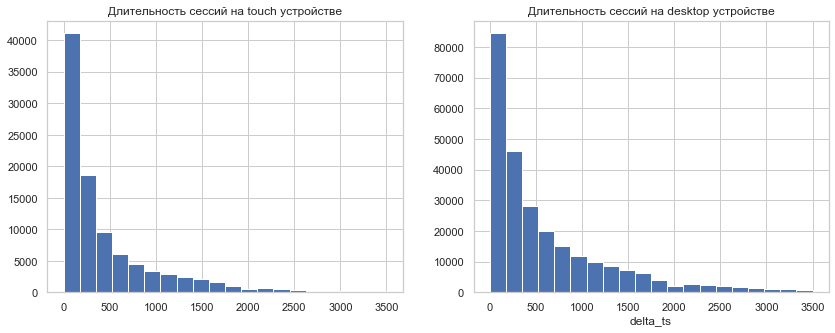

In [27]:
visits_length_touch = visits[visits['device'] == 'touch']['delta_ts']
fig, ax = plt.subplots(ncols=2, figsize=(14,5))
visits_length_touch.hist(
    bins=20, range=(0, 3500), ax=ax[0]
    ).set_title('Длительность сессий на touch устройстве')
plt.xlabel('delta_ts')


visits_length_desktop = visits[visits['device'] == 'desktop']['delta_ts']
visits_length_desktop.hist(
    bins=20, range=(0, 3500), ax=ax[1]
    ).set_title('Длительность сессий на desktop устройстве')
plt.xlabel('delta_ts')

Оба графика похожи между собой и отражают общее распределение длительности сессий. Чаще всего сессии короткие. Но если на touch устройстве хвост гистограммы заканчивается около 2500, то на desktop - около 3500. А значит на desktop сессии все же длиньше, чем на touch.

Рассчитаем среднюю длительность сессии.

In [28]:
length_touch = visits_length_touch.median()
print('{} сек - средняя длительность сессии на touch'.format(round(length_touch)))

180 сек - средняя длительность сессии на touch


In [29]:
length_desktop = visits_length_desktop.median()
print('{} сек - средняя длительность сессии на desktop'.format(round(length_desktop)))

360 сек - средняя длительность сессии на desktop


#### 2.1.4 Как часто люди возвращаются?

Чтобы ответить на этот вопрос, нужно рассчитать коэффициент удержания - Retention Rate. Для анализа будем использовать месячные когорты.

Разобьем пользователей на когорты по первой сессии. Сначала найдем дату первой сессии, затем добавим эту информацию в основной датафрейм. И расчитаем lifetime - сколько месяцев прошло с даты первой сессии.

In [30]:
first_date = visits.groupby(['uid'])['start_date'].min()
first_date.name = 'first_date'
first_date.head(5)

uid
11863502262781     2018-03-01
49537067089222     2018-02-06
297729379853735    2017-06-07
313578113262317    2017-09-18
325320750514679    2017-09-30
Name: first_date, dtype: object

In [31]:
visits = visits.join(first_date, on='uid')
visits['first_date'] = pd.to_datetime(visits['first_date'], format='%Y-%m-%d')
visits['first_month'] = visits['first_date'].astype('datetime64[M]')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')
visits['start_month'] = visits['start_ts'].astype('datetime64[M]')
visits.sample(5)

,device,end_ts,source_id,start_ts,uid,start_year,start_month,start_week,start_date,delta_ts,first_date,first_month
52750,desktop,2018-02-27 06:07:00,3,2018-02-27 06:03:00,11397387210740946042,2018,2018-02-01,9,2018-02-27,240,2017-06-30,2017-06-01
118178,touch,2018-02-18 09:10:00,3,2018-02-18 09:09:00,10493698863818228222,2018,2018-02-01,7,2018-02-18,60,2018-02-18,2018-02-01
222757,desktop,2018-03-12 10:47:00,3,2018-03-12 10:16:00,7648651307868769636,2018,2018-03-01,11,2018-03-12,1860,2018-03-12,2018-03-01
57634,touch,2017-10-01 11:46:00,3,2017-10-01 11:46:00,13898464183399473703,2017,2017-10-01,39,2017-10-01,0,2017-10-01,2017-10-01
273965,desktop,2018-03-01 14:42:00,4,2018-03-01 14:42:00,7174471488450855368,2018,2018-03-01,9,2018-03-01,0,2018-03-01,2018-03-01


In [32]:
visits['cohorts_lifetime'] = (visits['start_month'] - visits['first_month']) / np.timedelta64(1,'M')
visits['cohorts_lifetime'] = visits['cohorts_lifetime'].round().astype('int')
visits.sample(5)

,device,end_ts,source_id,start_ts,uid,start_year,start_month,start_week,start_date,delta_ts,first_date,first_month,cohorts_lifetime
356205,desktop,2018-02-07 11:42:00,4,2018-02-07 11:14:00,2291779799776736343,2018,2018-02-01,6,2018-02-07,1680,2018-02-06,2018-02-01,0
245621,desktop,2017-06-04 23:36:00,4,2017-06-04 23:34:00,9340118432157691823,2017,2017-06-01,22,2017-06-04,120,2017-06-04,2017-06-01,0
29490,touch,2017-10-01 21:18:00,5,2017-10-01 21:17:00,2198350911035658394,2017,2017-10-01,39,2017-10-01,60,2017-10-01,2017-10-01,0
82178,desktop,2017-08-27 21:03:00,1,2017-08-27 21:02:00,5856492816863094516,2017,2017-08-01,34,2017-08-27,60,2017-06-03,2017-06-01,2
184438,touch,2018-02-22 16:10:00,3,2018-02-22 16:08:00,17715627494667945555,2018,2018-02-01,8,2018-02-22,120,2018-02-22,2018-02-01,0


Найдем количество пользователей на каждый месяц существования когорты.

In [33]:
cohorts = visits.groupby(['first_month', 'cohorts_lifetime'])['uid'].nunique().reset_index()
cohorts.sample(5)

,first_month,cohorts_lifetime,uid
71,2018-02-01,3,446
5,2017-06-01,5,947
57,2017-12-01,0,25268
6,2017-06-01,6,809
63,2018-01-01,0,22624


Отдельной колонкой добавим в датафрейм начальное количество пользователей.

In [34]:
initual_users_count = cohorts[cohorts['cohorts_lifetime'] == 0][['first_month', 'uid']]
initual_users_count.columns = ['first_month', 'cohorts_uid']
initual_users_count.sample(5)

,first_month,cohorts_uid
23,2017-08-01,10181
75,2018-04-01,15709
0,2017-06-01,13259
68,2018-02-01,22197
33,2017-09-01,16704


In [35]:
cohorts = cohorts.merge(initual_users_count, on='first_month')
cohorts.sample(5)

,first_month,cohorts_lifetime,uid,cohorts_uid
12,2017-07-01,0,13140,13140
76,2018-04-01,1,760,15709
14,2017-07-01,2,674,13140
74,2018-03-01,2,557,20589
66,2018-01-01,3,565,22624


Рассчитаем коэффициент удержания.

In [36]:
cohorts['retention'] = cohorts['uid'] / cohorts['cohorts_uid']
cohorts.sample(5)

,first_month,cohorts_lifetime,uid,cohorts_uid,retention
73,2018-03-01,1,861,20589,0.041818
41,2017-09-01,8,381,16704,0.022809
12,2017-07-01,0,13140,13140,1.000000
55,2017-11-01,5,638,27248,0.023415
45,2017-10-01,3,1012,25977,0.038958


In [37]:
retention_pivot = cohorts.pivot_table(index='first_month', columns='cohorts_lifetime', values='retention', aggfunc='sum')
retention_pivot

cohorts_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


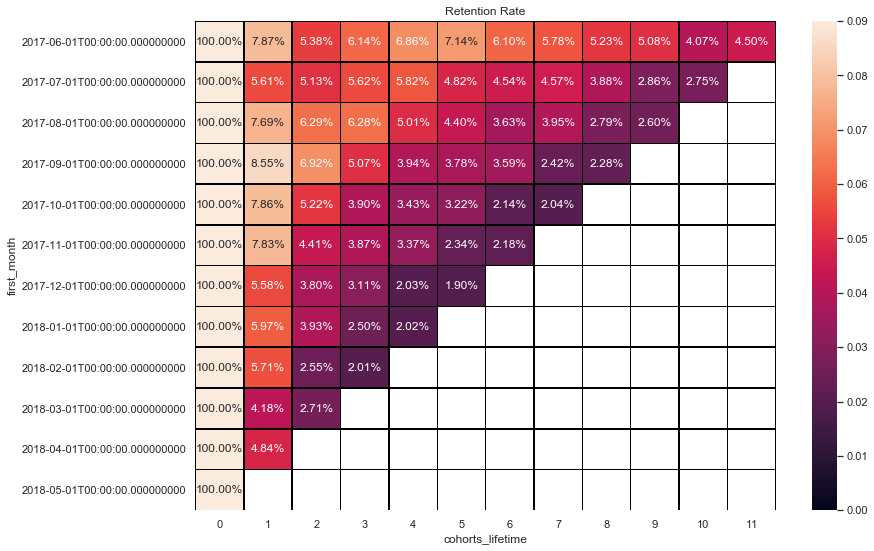

In [38]:
plt.figure(figsize=(13,9)) 
plt.title('Retention Rate')
sns.heatmap(retention_pivot, annot=True, fmt='.2%', vmin=0.0, vmax=0.09, linecolor='black', linewidths=0.5)

В зимние месяцы показатель падает во всех когортах и продолжает снижение и весной. Retention Rate людей, пришедших весной, в 1 месяц составляет столько же, сколько на 5 месяц когорт конца лета. Лучше всего показывает себя июньская когорта. По ней больше всего данных и видно, что в августе наблюдалось снижение, а с сентября, возможно внесли изменения, которые положительно повлияли на метрику, и только в ноябре снова пошло снижение. Такие данные могут носить сезонный характер, либо зависеть, например, от смены источника трафика. 

#### Устройства

Найдем количество пользователей на каждый месяц существования когорты.

In [39]:
cohorts_d = visits.groupby(['first_month', 'cohorts_lifetime', 'device'])['uid'].nunique().reset_index()
cohorts_d.sample(5)

,first_month,cohorts_lifetime,device,uid
1,2017-06-01,0,touch,3655
124,2017-12-01,5,desktop,371
50,2017-08-01,2,desktop,492
12,2017-06-01,6,desktop,656
80,2017-09-01,7,desktop,302


Отдельной колонкой добавим в датафрейм начальное количество пользователей.

In [40]:
initual_users_count_d = cohorts_d[cohorts_d['cohorts_lifetime'] == 0][['first_month', 'device', 'uid']]
initual_users_count_d.columns = ['first_month', 'device', 'cohorts_uid']

cohorts_d = cohorts_d.merge(initual_users_count_d, on=['first_month', 'device'])
cohorts_d.sample(5)

,first_month,cohorts_lifetime,device,uid,cohorts_uid
77,2017-09-01,2,touch,316,5133
106,2017-11-01,6,desktop,451,20129
104,2017-11-01,4,desktop,681,20129
123,2017-12-01,3,touch,237,7100
57,2017-08-01,1,touch,199,2796


Рассчитаем коэффициент удержания.

In [41]:
cohorts_d['retention'] = cohorts_d['uid'] / cohorts_d['cohorts_uid']

Отобразим Retention Rate по устройствам.

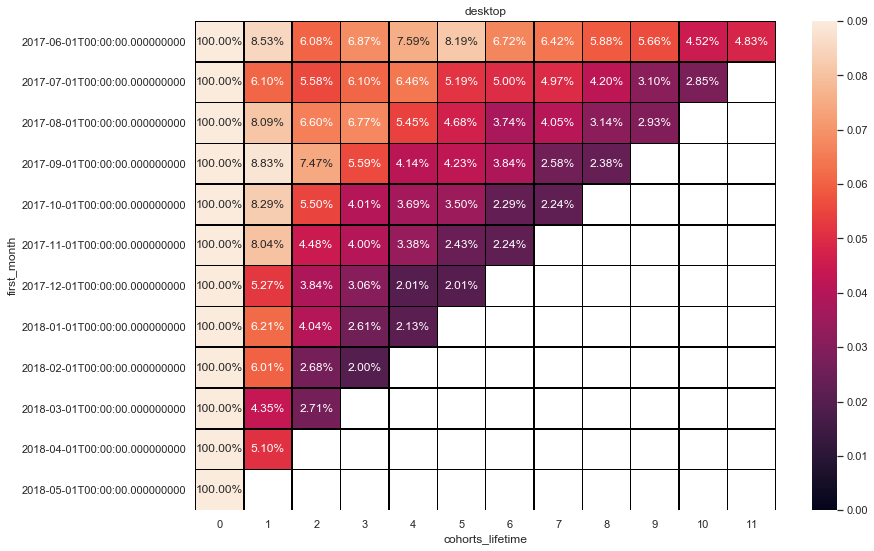

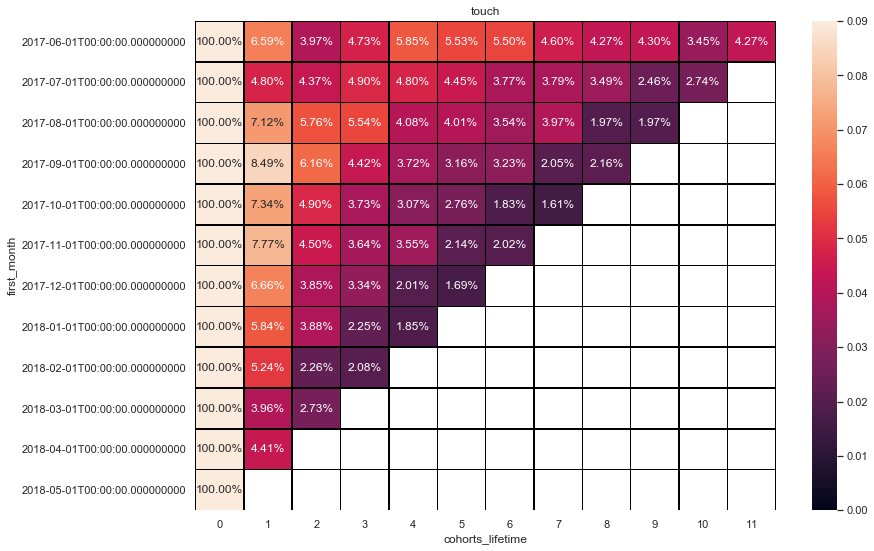

In [42]:
list_device = cohorts_d['device'].unique().tolist()

for device in list_device:
    retention_pivot_d = cohorts_d[cohorts_d['device'] == device].pivot_table(
        index='first_month', columns='cohorts_lifetime', values='retention', aggfunc='sum')
    plt.figure(figsize=(13,9)) 
    sns.heatmap(
        retention_pivot_d, annot=True, fmt='.2%', vmin=0.0, vmax=0.09, linecolor='black', linewidths=0.5
    ).set_title(device)    

### 2.2 Продажи

#### 2.2.1 Когда люди начинают покупать?

Найдем, когда была первая покупка. Добавим данные о дате первой сессии.

In [43]:
first_order = orders.groupby('uid')['buy_ts'].min().reset_index()
first_order.columns = ['uid','first_order']
first_order_days = first_order.merge(first_date, on='uid')
first_order_days['first_order'] = first_order_days['first_order'].astype('datetime64[D]')
first_order_days['first_date'] = first_order_days['first_date'].astype('datetime64[D]')
first_order_days.head(5)

,uid,first_order,first_date
0,313578113262317,2018-01-03,2017-09-18
1,1575281904278712,2017-06-03,2017-06-03
2,2429014661409475,2017-10-11,2017-10-11
3,2464366381792757,2018-01-28,2018-01-27
4,2551852515556206,2017-11-24,2017-11-24


Найдем разницу между датой первой сессии и даты первой покупки.

In [44]:
first_order_days['time_to_first_order'] = (
    first_order_days['first_order'] - first_order_days['first_date']
                                          ) / np.timedelta64(1,'D')
first_order_days.head(5)

,uid,first_order,first_date,time_to_first_order
0,313578113262317,2018-01-03,2017-09-18,107.0
1,1575281904278712,2017-06-03,2017-06-03,0.0
2,2429014661409475,2017-10-11,2017-10-11,0.0
3,2464366381792757,2018-01-28,2018-01-27,1.0
4,2551852515556206,2017-11-24,2017-11-24,0.0


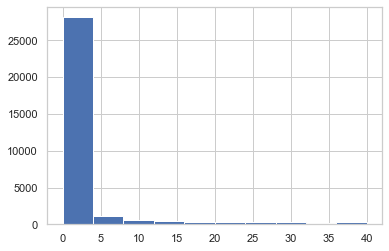

In [45]:
first_order_days['time_to_first_order'].astype('int').hist(bins=10, range=(0,40))

In [46]:
first_order_days['time_to_first_order'].mode()[0]

0.0

#### 2.2.2 Сколько раз покупают за период?

Рассмотрим показатель по месяцам.

In [47]:
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')
order_per_user = orders.groupby('buy_month').agg({'uid':['count', 'nunique']})
order_per_user.columns = ['n_orders', 'n_users']
order_per_user['order_per_user'] = round(order_per_user['n_orders'] / order_per_user['n_users'], 2)
order_per_user

,n_orders,n_users,order_per_user
buy_month,,,
2017-06-01,2354,2023,1.16
2017-07-01,2363,1984,1.19
2017-08-01,1807,1472,1.23
2017-09-01,3387,2750,1.23
2017-10-01,5679,4675,1.21
2017-11-01,5659,4547,1.24
2017-12-01,6218,4942,1.26
2018-01-01,4721,3898,1.21
2018-02-01,5281,4258,1.24


In [48]:
print('{} покупок на одного пользователя в месяц'.format(round(order_per_user['order_per_user'].median(), 2)))

1.23 покупок на одного пользователя в месяц


#### 2.2.3 Какой средний чек?

Средний чек по месяцам.

In [49]:
revenue_grouped_by_cohorts = orders.groupby(['buy_month']).agg({'revenue':'mean'})
revenue_grouped_by_cohorts.reset_index()

,buy_month,revenue
0,2017-06-01,4.060106
1,2017-07-01,5.306589
2,2017-08-01,4.847139
3,2017-09-01,5.416448
4,2017-10-01,4.928280
5,2017-11-01,4.783518
6,2017-12-01,5.852139
7,2018-01-01,4.112927
8,2018-02-01,4.840095
9,2018-03-01,5.413930


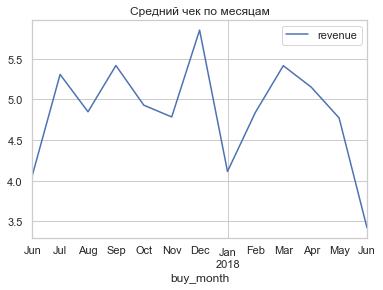

In [50]:
revenue_grouped_by_cohorts.plot(title='Средний чек по месяцам')

Сильнее всего средний чек вырос в декабре, что может быть связано с наступающими праздниками. А в январе наоборот произошёл сильный спад. Но уже в феврале показатель вернулся к среднему значению.

In [51]:
revenue_mean = orders['revenue'].mean()
print('Средний чек', round(revenue_mean, 2))

Средний чек 5.0


#### 2.2.4 Сколько денег приносят?

Добавим в основную таблицу данные о первой покупке.

In [52]:
orders = orders.merge(first_order, on='uid')
orders['first_order'] = pd.to_datetime(orders['first_order'], format='%Y-%m-%d %H:%M:%S')
orders['first_month'] = orders['first_order'].astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,buy_month,first_order,first_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01


Посчитаем количество уникальных покупателей за каждый месяц.

In [53]:
cohort_size = orders.groupby(['first_month']).agg({'uid':'nunique'}).reset_index()
cohort_size.head()

,first_month,uid
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Посчитаем количество покупок в месяц.

In [54]:
orders_grouped_by_cohorts = orders.groupby(['first_month', 'buy_month']).agg({'revenue':'sum'}).reset_index()
orders_grouped_by_cohorts = orders_grouped_by_cohorts.merge(cohort_size, on='first_month')
orders_grouped_by_cohorts.head()

,first_month,buy_month,revenue,uid
0,2017-06-01,2017-06-01,9557.49,2023
1,2017-06-01,2017-07-01,981.82,2023
2,2017-06-01,2017-08-01,885.34,2023
3,2017-06-01,2017-09-01,1931.30,2023
4,2017-06-01,2017-10-01,2068.58,2023


LTV по месяцам.

In [55]:
orders_grouped_by_cohorts['ltv'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']
orders_grouped_by_cohorts['lifetime'] = (
    orders_grouped_by_cohorts['buy_month'] - orders_grouped_by_cohorts['first_month']
) / np.timedelta64(1, 'M')
orders_grouped_by_cohorts['lifetime'] = orders_grouped_by_cohorts['lifetime'].round().astype('int')
orders_grouped_by_cohorts.head()

,first_month,buy_month,revenue,uid,ltv,lifetime
0,2017-06-01,2017-06-01,9557.49,2023,4.724414,0
1,2017-06-01,2017-07-01,981.82,2023,0.485329,1
2,2017-06-01,2017-08-01,885.34,2023,0.437637,2
3,2017-06-01,2017-09-01,1931.30,2023,0.954671,3
4,2017-06-01,2017-10-01,2068.58,2023,1.022531,4


LTV по когортам и lifetime.

In [56]:
ltv_pivot = orders_grouped_by_cohorts.pivot_table(
    index='first_month', columns='lifetime', values='ltv', aggfunc='mean').round(2)
ltv_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_month,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,NaN
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,NaN,NaN
2017-09-01,5.64,1.12,0.52,3.98,0.40,0.65,0.70,0.24,0.18,NaN,NaN,NaN
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,NaN,NaN,NaN,NaN
2017-11-01,5.15,0.40,0.20,0.32,0.15,0.05,0.11,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.14,0.29,0.30,0.14,0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.16,0.28,0.08,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


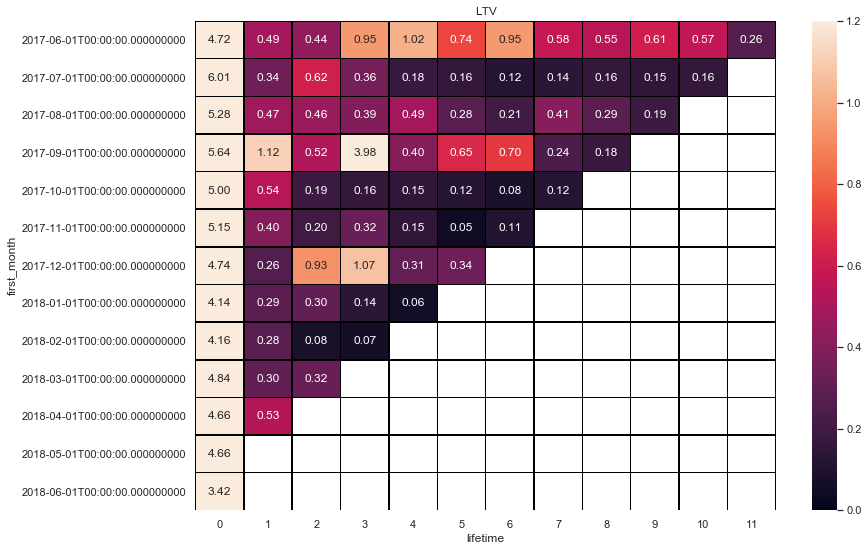

In [57]:
plt.figure(figsize=(13,9)) 
plt.title('LTV')
sns.heatmap(ltv_pivot, annot=True, fmt='.2f', vmin=0.0, vmax=1.2, linecolor='black', linewidths=0.5)

Средний LTV по когортам.

In [58]:
ltv_mean = orders_grouped_by_cohorts.pivot_table(index='first_month', values='ltv', aggfunc='mean').round(2)
ltv_mean

,ltv
first_month,
2017-06-01,0.99
2017-07-01,0.76
2017-08-01,0.85
2017-09-01,1.49
2017-10-01,0.80
2017-11-01,0.91
2017-12-01,1.27
2018-01-01,0.99
2018-02-01,1.15


Сумма LTV за 6 месяцев. Расчеты проведем только с когортами, у которых есть данные за 6 месяцев.

In [59]:
orders_six_month = orders_grouped_by_cohorts[(
    orders_grouped_by_cohorts['lifetime'] < 6) & (
    orders_grouped_by_cohorts['first_month'] < '2018-01-01')]
orders_six_month.head(5)

,first_month,buy_month,revenue,uid,ltv,lifetime
0,2017-06-01,2017-06-01,9557.49,2023,4.724414,0
1,2017-06-01,2017-07-01,981.82,2023,0.485329,1
2,2017-06-01,2017-08-01,885.34,2023,0.437637,2
3,2017-06-01,2017-09-01,1931.30,2023,0.954671,3
4,2017-06-01,2017-10-01,2068.58,2023,1.022531,4


In [60]:
ltv_sum = orders_six_month.pivot_table(index='first_month', values='ltv', aggfunc='sum').round(2).reset_index()
ltv_sum

,first_month,ltv
0,2017-06-01,8.36
1,2017-07-01,7.66
2,2017-08-01,7.38
3,2017-09-01,12.31
4,2017-10-01,6.16
5,2017-11-01,6.28
6,2017-12-01,7.64


Июньская, сентябрьская когорты имеют самый высокий показатель.

#### Устройства

Создадим общую таблицу.

In [61]:
orders['start_date'] = orders['buy_ts'].astype('datetime64[D]')
visits['start_date'] = visits['start_date'].astype('datetime64[D]')
orders_visits = orders.merge(visits[['start_date', 'uid', 'source_id', 'device']], on=['uid', 'start_date'])
orders_visits.head()

,buy_ts,revenue,uid,buy_month,first_order,first_month,start_date,source_id,device
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,2017-06-01,1,desktop
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,2017-06-01,2,desktop
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01,2017-06-01,2,desktop
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01,2017-06-01,2,desktop
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01,2017-06-01,3,desktop


Рассчитаем lifetime.

In [62]:
orders_visits['lifetime'] = (
    orders_visits['buy_month'] - orders_visits['first_month']
) / np.timedelta64(1, 'M')
orders_visits['lifetime'] = orders_visits['lifetime'].round().astype('int')
orders_visits.sample(5)

,buy_ts,revenue,uid,buy_month,first_order,first_month,start_date,source_id,device,lifetime
24713,2017-11-24 10:10:00,5.13,6264063680107836503,2017-11-01,2017-11-24 10:10:00,2017-11-01,2017-11-24,2,desktop,0
10244,2017-08-28 13:43:00,12.22,11652986979716232078,2017-08-01,2017-08-28 13:43:00,2017-08-01,2017-08-28,2,desktop,0
8013,2017-12-15 13:34:00,1.83,14796385994327223011,2017-12-01,2017-07-21 21:53:00,2017-07-01,2017-12-15,3,desktop,5
46440,2018-03-20 22:48:00,1.22,15250396047001603898,2018-03-01,2018-03-20 22:48:00,2018-03-01,2018-03-20,4,desktop,0
36623,2018-01-20 21:15:00,2.14,2530616148483495454,2018-01-01,2018-01-20 21:15:00,2018-01-01,2018-01-20,4,desktop,0


In [63]:
order_per_user_d = orders_visits.groupby(['device']).agg({'uid':['count', 'nunique']})
order_per_user_d.columns = ['n_orders', 'n_users']
order_per_user_d['order_per_user'] = round(order_per_user_d['n_orders'] / order_per_user_d['n_users'], 2)
order_per_user_d

,n_orders,n_users,order_per_user
device,,,
desktop,45734,26785,1.71
touch,9294,6126,1.52


Посчитаем количество уникальных покупателей за каждый месяц.

Заказов с desktop в 5 раз больше, чем с touch. А пользователей больше в 4,4. В среднем пользователь desktop заказывает чаще.

In [64]:
cohort_size_d = orders_visits.groupby(['first_month', 'device']).agg({'uid':'nunique'}).reset_index()
cohort_size_d.head()

,first_month,device,uid
0,2017-06-01,desktop,1658
1,2017-06-01,touch,325
2,2017-07-01,desktop,1459
3,2017-07-01,touch,358
4,2017-08-01,desktop,1048


Рассчитаем LTV.

In [65]:
ltv_device = orders_visits.groupby(
    ['first_month', 'device', 'lifetime']
).agg({'revenue':'sum'}).reset_index()

ltv_device = ltv_device.merge(cohort_size_d, on=['first_month', 'device'])
ltv_device['ltv'] = ltv_device['revenue'] / ltv_device['uid']
ltv_device.head()

,first_month,device,lifetime,revenue,uid,ltv
0,2017-06-01,desktop,0,10583.26,1658,6.383148
1,2017-06-01,desktop,1,900.25,1658,0.542973
2,2017-06-01,desktop,2,1052.51,1658,0.634807
3,2017-06-01,desktop,3,2606.27,1658,1.571936
4,2017-06-01,desktop,4,2634.52,1658,1.588975


LTV для desktop.

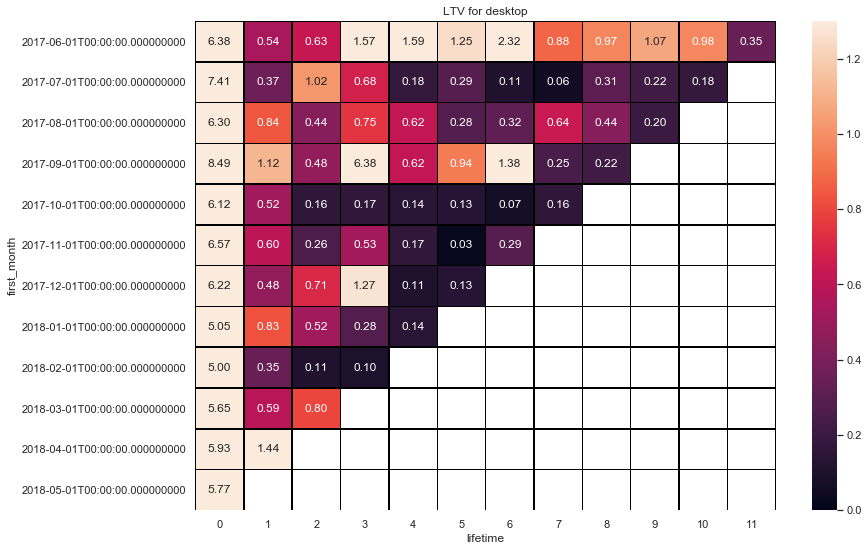

In [66]:
ltv_desktop_pivot = ltv_device[ltv_device['device'] == 'desktop'].pivot_table(
    index='first_month', columns='lifetime', values='ltv', aggfunc='mean').round(2)

plt.figure(figsize=(13,9)) 
plt.title('LTV for desktop')
sns.heatmap(ltv_desktop_pivot, annot=True, fmt='.2f', vmin=0.0, vmax=1.3, linecolor='black', linewidths=0.5)

В течение lifetime июньская и сентябрьская когорты выделяются так как имеют более высокие показатели. 

LTV для touch.

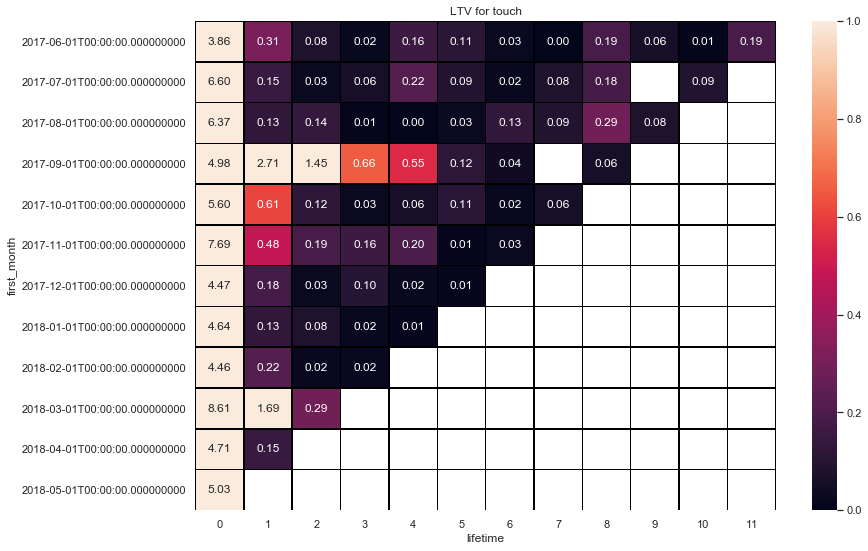

In [67]:
ltv_touch_pivot = ltv_device[ltv_device['device'] == 'touch'].pivot_table(
    index='first_month', columns='lifetime', values='ltv', aggfunc='mean').round(2)

plt.figure(figsize=(13,9)) 
plt.title('LTV for touch')
sns.heatmap(ltv_touch_pivot, annot=True, fmt='.2f', vmin=0.0, vmax=1, linecolor='black', linewidths=0.5)

touch показатели сильно уступают desktop. Только сентябрьская когорта имеет LTV выше 0.5 дольше нескольких месяцев.

#### Источники

Посчитаем количество уникальных покупателей за каждый месяц.

In [68]:
cohort_size_s = orders_visits.groupby(['first_month', 'source_id']).agg({'uid':'nunique'}).reset_index()
cohort_size_s.head()

,first_month,source_id,uid
0,2017-06-01,1,317
1,2017-06-01,2,326
2,2017-06-01,3,656
3,2017-06-01,4,460
4,2017-06-01,5,448


Рассчитаем LTV по источникам.

In [69]:
ltv_source = orders_visits.groupby(
    ['first_month', 'source_id', 'lifetime']
).agg({'revenue':'sum'}).reset_index()

ltv_source = ltv_source.merge(cohort_size_s, on=['first_month', 'source_id'])

ltv_source['ltv'] = ltv_source['revenue'] / ltv_source['uid']
ltv_source.head()

,first_month,source_id,lifetime,revenue,uid,ltv
0,2017-06-01,1,0,2294.58,317,7.238423
1,2017-06-01,1,1,294.39,317,0.928675
2,2017-06-01,1,2,214.59,317,0.676940
3,2017-06-01,1,3,596.28,317,1.881009
4,2017-06-01,1,4,776.12,317,2.448328


In [70]:
list_source = ltv_source['source_id'].unique().tolist()
list_source.sort()

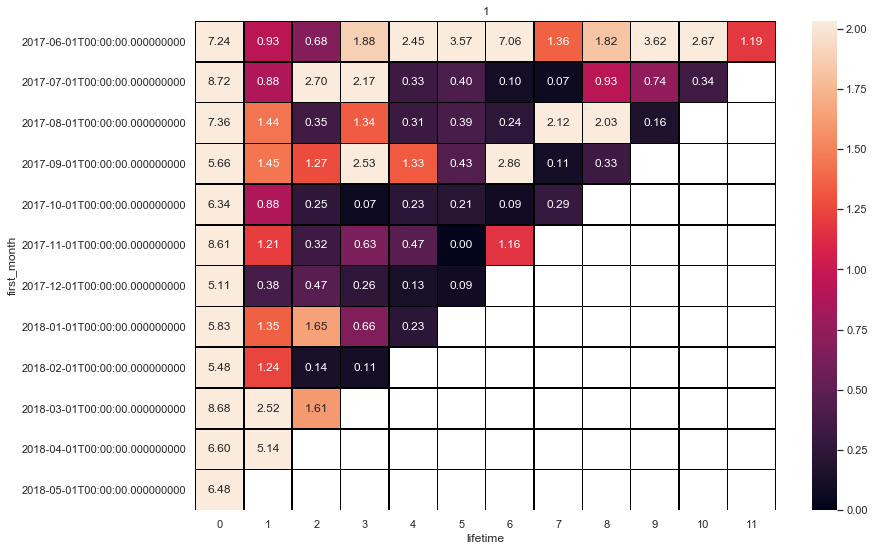

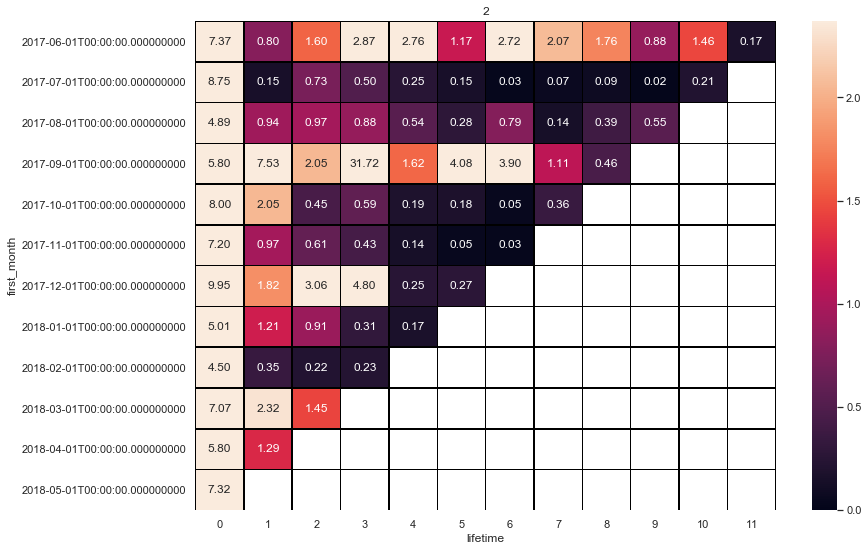

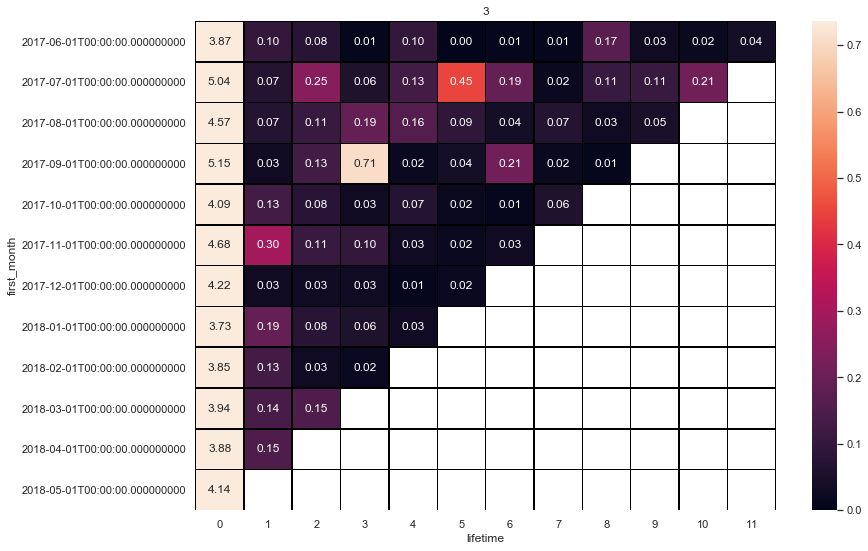

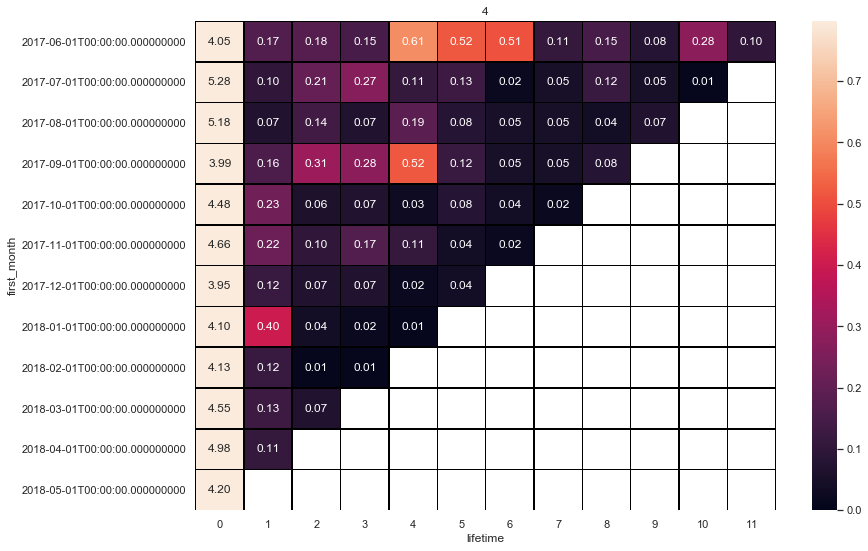

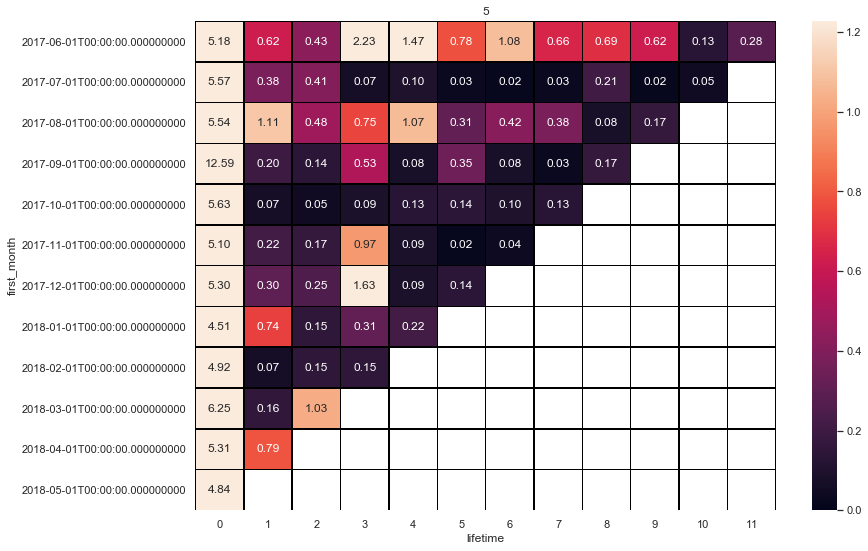

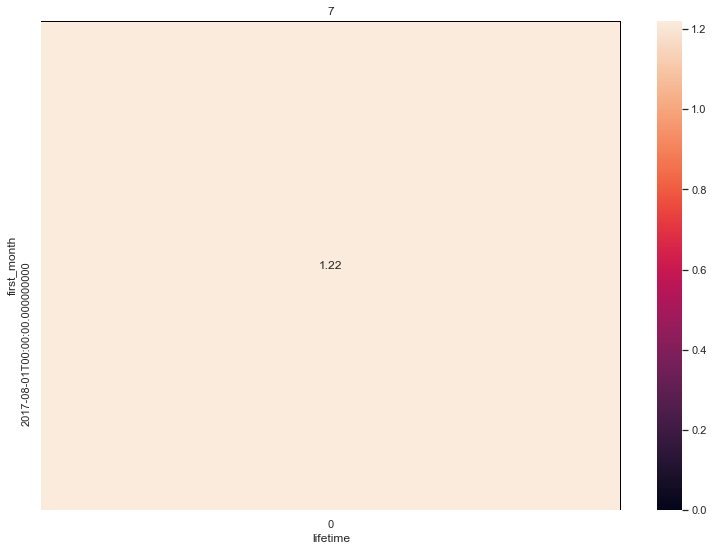

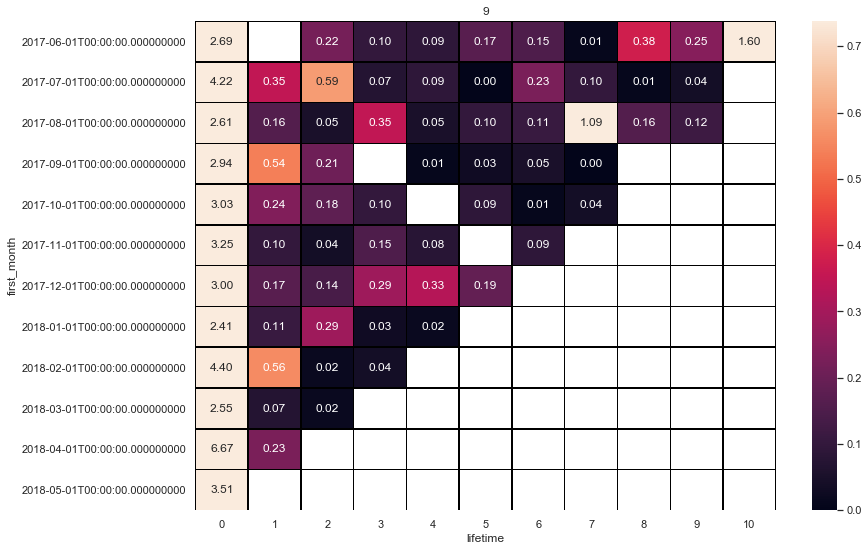

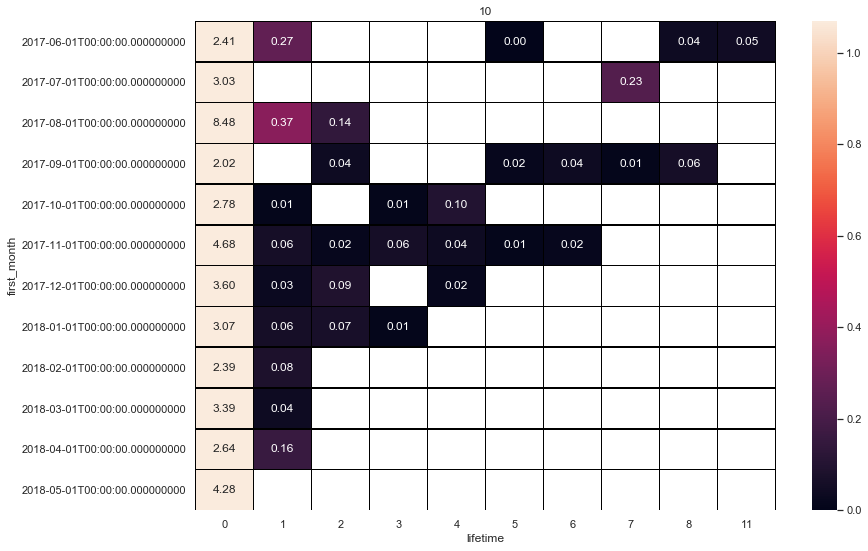

In [71]:
for el in list_source:
    ltv_n = ltv_source[ltv_source['source_id'] == el]
    ltv_source_pivot = ltv_n.pivot_table(
        index='first_month', columns='lifetime', values='ltv', aggfunc='mean').round(2)
    plt.figure(figsize=(13,9)) 
    plt.title(el)
    sns.heatmap(
        ltv_source_pivot, annot=True, fmt='.2f', vmin=0.0, vmax=ltv_n['ltv'].mean(), linecolor='black', linewidths=0.5)

1,2 и 5 источник имеют самую высокую метрику. По 7 слишком мало данных.

Сколько в среднем приносит покупатель с источника. Рассчитаем только по когортам, которые имеют данные за 6 и более мес.

In [72]:
source_ltv_six_month = ltv_source[ltv_source['first_month'] <= '2017-12-01'].groupby(['source_id']).agg({'ltv':'mean'})
source_ltv_six_month

,ltv
source_id,
1,1.757669
2,2.328525
3,0.585916
4,0.624777
5,1.050192
7,1.220000
9,0.562084
10,0.927205


### 2.3 Маркетинг

#### 2.3.1 Сколько денег потратили? Всего / на каждый источник / по времени

In [73]:
total_costs = costs['costs'].sum()
print(total_costs, '- всего потрачено на привлечение пользователей')

329131.62 - всего потрачено на привлечение пользователей


Потрачено на каждый источник.

In [74]:
costs_for_source = costs.groupby('source_id')['costs'].sum()
costs_for_source

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

Потрачено в месяц.

In [75]:
costs['dt_month'] = costs['dt'].astype('datetime64[M]')
costs_per_month = costs.groupby(['dt_month', 'source_id'])['costs'].sum()
costs_per_month.head(10)

dt_month    source_id
2017-06-01  1            1125.61
            2            2427.38
            3            7731.65
            4            3514.80
            5            2616.12
            9             285.22
            10            314.22
2017-07-01  1            1072.88
            2            2333.11
            3            7674.37
Name: costs, dtype: float64

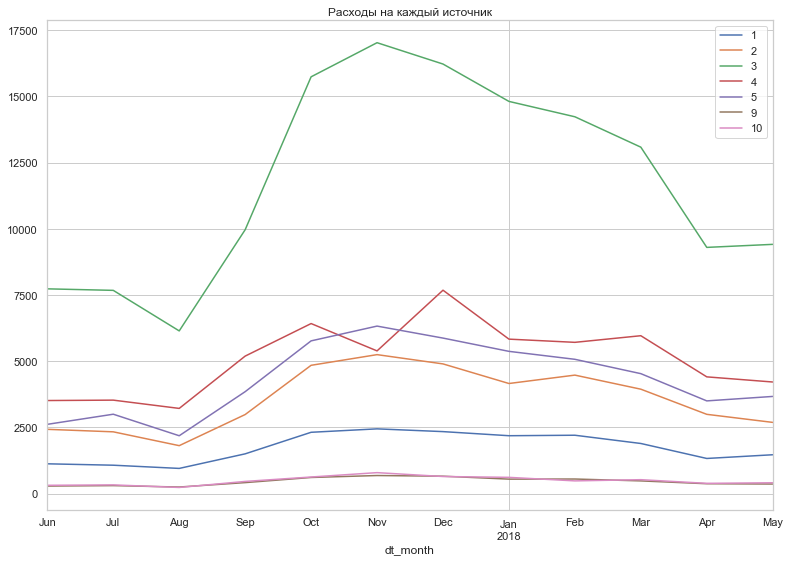

In [76]:
plt.figure(figsize=(13,9))
plt.title('Расходы на каждый источник')
for el in costs['source_id'].unique().tolist():
    costs[costs['source_id'] == el]\
    .groupby('dt_month')['costs']\
    .sum()\
    .plot(kind='line', x='dt_month', y='costs')
plt.legend(costs['source_id'].unique().tolist())

Больше всего вкладывались в 3 источник на протяжении всего времени. Меньше всего - в 1, 9 и 10.


#### 2.3.2 Сколько стоило привлечение одного покупателя из каждого источника?

Рассчитаем, сколько покупателей пришло по каждому источнику.

In [77]:
n_buyers_per_source = orders_visits.groupby(['first_month', 'source_id'])['uid'].nunique().reset_index()
n_buyers_per_source.columns = ['first_month', 'source_id', 'n_buyers']
n_buyers_per_source.head(5)

,first_month,source_id,n_buyers
0,2017-06-01,1,317
1,2017-06-01,2,326
2,2017-06-01,3,656
3,2017-06-01,4,460
4,2017-06-01,5,448


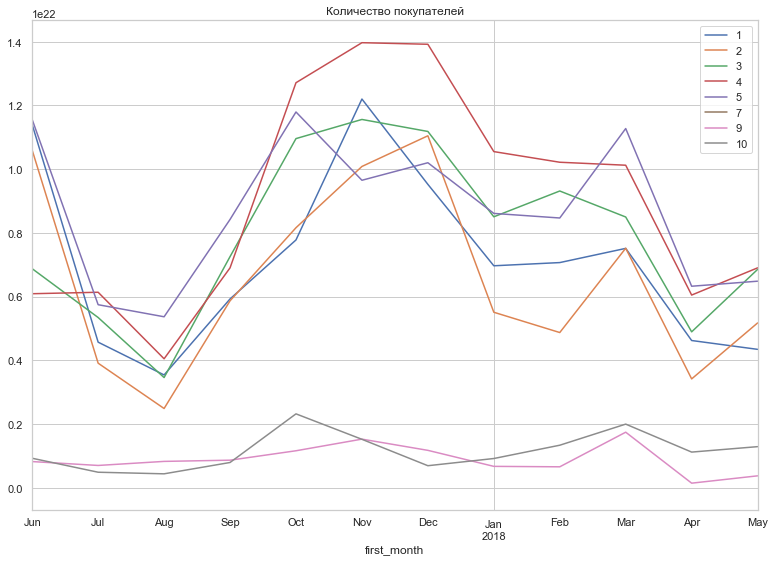

In [78]:
list_source = orders_visits['source_id'].unique().tolist()
list_source.sort()

plt.figure(figsize=(13,9))
plt.title('Количество покупателей')
for el in list_source:
    orders_visits[orders_visits['source_id'] == el]\
    .groupby('first_month')['uid']\
    .sum()\
    .plot(kind='line', x='first_month', y='uid')
plt.legend(list_source)

Не смотря на то, что вкладывались больше в 3 источник, больше всего покупателей привлек 4 источник. Меньше всего клиентов поступило с 9 и 10.

Соединим датасеты с количеством покупателей и потраченной сумме на привлечение.

In [79]:
costs_per_month = costs_per_month.reset_index()
costs_per_month.columns = ['first_month', 'source_id', 'costs']
cac = costs_per_month.merge(n_buyers_per_source, on=['first_month', 'source_id'])
cac.head(5)

,first_month,source_id,costs,n_buyers
0,2017-06-01,1,1125.61,317
1,2017-06-01,2,2427.38,326
2,2017-06-01,3,7731.65,656
3,2017-06-01,4,3514.80,460
4,2017-06-01,5,2616.12,448


Рассчитаем CAC по месяцам.

In [80]:
cac['cac'] = cac['costs'] / cac['n_buyers']
cac.head(5)

,first_month,source_id,costs,n_buyers,cac
0,2017-06-01,1,1125.61,317,3.550820
1,2017-06-01,2,2427.38,326,7.445951
2,2017-06-01,3,7731.65,656,11.786052
3,2017-06-01,4,3514.80,460,7.640870
4,2017-06-01,5,2616.12,448,5.839554


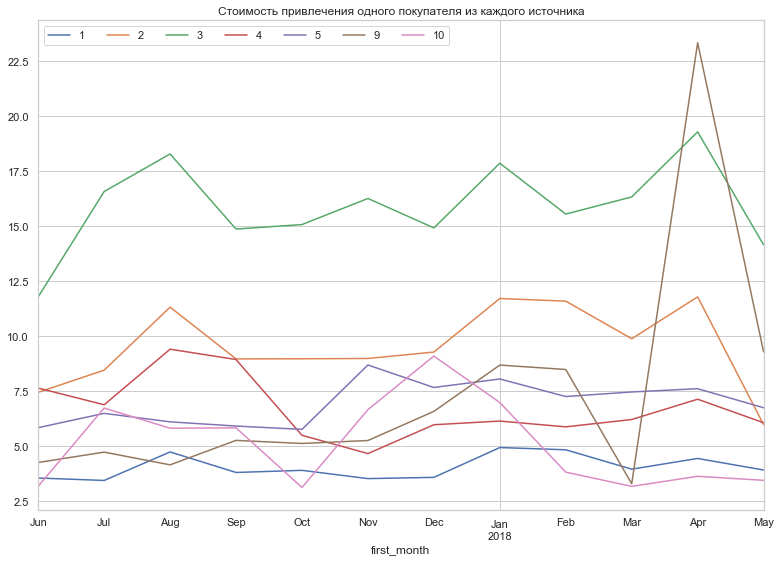

In [81]:
list_source_cac = cac['source_id'].unique().tolist()
list_source_cac.sort()

plt.figure(figsize=(13,9))
plt.title('Стоимость привлечения одного покупателя из каждого источника')
for el in list_source_cac:
    cac[cac['source_id'] == el]\
    .groupby('first_month')['cac']\
    .mean()\
    .plot(kind='line', x='first_month', y='cac')
plt.legend(list_source_cac, ncol=len(list_source_cac), loc='upper left')

В целом, дешевле всего обходится привлечение покупателей из 1 источника. Дороже - из 3.

Посчитаем, сколько в среднем стоило привлечение покупателя из каждого источника. В расчет возьмем данные для когорт, по которым есть информация за 6 и более мес.

In [82]:
cac_mean = cac[cac['first_month'] <= '2017-12-01'].groupby('source_id')['cac'].mean()
cac_mean

source_id
1      3.789877
2      9.059767
3     15.396157
4      6.998894
5      6.637513
9      5.050025
10     5.775169
Name: cac, dtype: float64

In [83]:
source_ltv_six_month.merge(cac_mean, on='source_id')

,ltv,cac
source_id,,
1,1.757669,3.789877
2,2.328525,9.059767
3,0.585916,15.396157
4,0.624777,6.998894
5,1.050192,6.637513
9,0.562084,5.050025
10,0.927205,5.775169


По всем источникам трафика средние показатели LTV уступают CAC.

#### 2.3.3 На сколько окупились расходы?

Количество покупателей по месяцам. 

In [84]:
count_costs = orders_visits.groupby(['first_month']).agg({'uid':'nunique'}).reset_index()
count_costs.head()

,first_month,uid
0,2017-06-01,1926
1,2017-07-01,1772
2,2017-08-01,1250
3,2017-09-01,2321
4,2017-10-01,3915


Добавим количество покупателей и LTV в основную таблицу.

In [85]:
report = orders_visits.groupby(['first_month', 'buy_month','lifetime'])['revenue'].sum().reset_index()
report = report.merge(count_costs, on=['first_month'])
report['ltv'] = report['revenue'] / report['uid']
report.head(5)

,first_month,buy_month,lifetime,revenue,uid,ltv
0,2017-06-01,2017-06-01,0,11838.34,1926,6.146594
1,2017-06-01,2017-07-01,1,1000.45,1926,0.519444
2,2017-06-01,2017-08-01,2,1079.09,1926,0.560275
3,2017-06-01,2017-09-01,3,2614.21,1926,1.357326
4,2017-06-01,2017-10-01,4,2688.00,1926,1.395639


Добавим к основной таблице затраты по месяцам. Рассчитаем CAC.

In [86]:
costs['first_month'] = costs['dt_month'].astype('datetime64[M]')
report = report.merge(costs.groupby('first_month')['costs'].sum(), on='first_month')
report['cac'] = report['costs'] / report['uid']
report.head(5)

,first_month,buy_month,lifetime,revenue,uid,ltv,costs,cac
0,2017-06-01,2017-06-01,0,11838.34,1926,6.146594,18015.0,9.353583
1,2017-06-01,2017-07-01,1,1000.45,1926,0.519444,18015.0,9.353583
2,2017-06-01,2017-08-01,2,1079.09,1926,0.560275,18015.0,9.353583
3,2017-06-01,2017-09-01,3,2614.21,1926,1.357326,18015.0,9.353583
4,2017-06-01,2017-10-01,4,2688.00,1926,1.395639,18015.0,9.353583


Рассчитаем ROMI.

In [87]:
report['romi'] = report['ltv'] / report['cac']

In [88]:
romi_pivot = report.pivot_table(
    index='first_month', columns='lifetime', values='romi', aggfunc='mean')
romi_pivot = romi_pivot.cumsum(axis=1).round(2)
romi_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_month,,,,,,,,,,,,
2017-06-01,0.66,0.71,0.77,0.92,1.07,1.18,1.40,1.48,1.57,1.67,1.76,1.8
2017-07-01,0.72,0.75,0.84,0.89,0.91,0.94,0.94,0.95,0.98,1.00,1.01,NaN
2017-08-01,0.54,0.61,0.64,0.69,0.74,0.76,0.78,0.83,0.86,0.88,NaN,NaN
2017-09-01,0.76,0.90,0.96,1.48,1.54,1.61,1.72,1.74,1.76,NaN,NaN,NaN
2017-10-01,0.67,0.72,0.74,0.76,0.77,0.78,0.79,0.81,NaN,NaN,NaN,NaN
2017-11-01,0.66,0.72,0.75,0.79,0.81,0.81,0.83,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.60,0.64,0.70,0.81,0.82,0.83,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.44,0.50,0.54,0.56,0.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.48,0.51,0.52,0.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
romi_pivot.mean(axis=0)

lifetime
0     0.610000
1     0.670909
2     0.725000
3     0.825556
4     0.903750
5     0.987143
6     1.076667
7     1.162000
8     1.292500
9     1.183333
10    1.385000
11    1.800000
dtype: float64

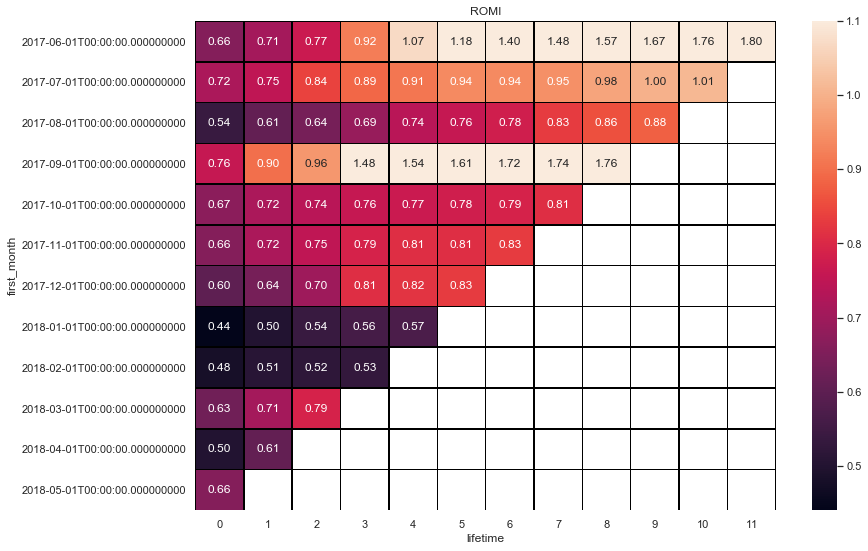

In [90]:
plt.figure(figsize=(13,9)) 
plt.title('ROMI')
sns.heatmap(romi_pivot, annot=True, fmt='.2f', linecolor='black', vmax=1.1, linewidths=0.5)

По средней когорте окупаемость на 7 месяце. По всем когортам видно, что окупились только июньская (за 5 мес), июльская (за 10 мес) и сентябрьская (за 4 мес.). Остальные не окупились.



#### Источники

Количество покупателей по месяцам по источникам.

In [91]:
count_costs_source = orders_visits.groupby(['first_month', 'source_id']).agg({'uid':'nunique'}).reset_index()
count_costs_source.head(5)

,first_month,source_id,uid
0,2017-06-01,1,317
1,2017-06-01,2,326
2,2017-06-01,3,656
3,2017-06-01,4,460
4,2017-06-01,5,448


Добавим количество покупателей и LTV в основную таблицу.

In [92]:
report_source = orders_visits.groupby(['first_month', 'source_id', 'buy_month', 'lifetime'])['revenue'].sum().reset_index()
report_source = report_source.merge(count_costs_source, on=['first_month', 'source_id'])
report_source.head(5)

,first_month,source_id,buy_month,lifetime,revenue,uid
0,2017-06-01,1,2017-06-01,0,2294.58,317
1,2017-06-01,1,2017-07-01,1,294.39,317
2,2017-06-01,1,2017-08-01,2,214.59,317
3,2017-06-01,1,2017-09-01,3,596.28,317
4,2017-06-01,1,2017-10-01,4,776.12,317


In [93]:
report_source['ltv'] = report_source['revenue'] / report_source['uid']
report_source.head(5)

,first_month,source_id,buy_month,lifetime,revenue,uid,ltv
0,2017-06-01,1,2017-06-01,0,2294.58,317,7.238423
1,2017-06-01,1,2017-07-01,1,294.39,317,0.928675
2,2017-06-01,1,2017-08-01,2,214.59,317,0.676940
3,2017-06-01,1,2017-09-01,3,596.28,317,1.881009
4,2017-06-01,1,2017-10-01,4,776.12,317,2.448328


Добавим к основной таблице затраты по месяцам. Рассчитаем CAC.

In [94]:
report_source = report_source.merge(
    costs.groupby(['first_month', 'source_id'])['costs'].sum(), on=['first_month', 'source_id'])
report_source['cac'] = report_source['costs'] / report_source['uid']
report_source.head(5)

,first_month,source_id,buy_month,lifetime,revenue,uid,ltv,costs,cac
0,2017-06-01,1,2017-06-01,0,2294.58,317,7.238423,1125.61,3.55082
1,2017-06-01,1,2017-07-01,1,294.39,317,0.928675,1125.61,3.55082
2,2017-06-01,1,2017-08-01,2,214.59,317,0.676940,1125.61,3.55082
3,2017-06-01,1,2017-09-01,3,596.28,317,1.881009,1125.61,3.55082
4,2017-06-01,1,2017-10-01,4,776.12,317,2.448328,1125.61,3.55082


Рассчитаем ROMI.

In [95]:
report_source['romi'] = report_source['ltv'] / report_source['cac']

Отобразим ROMI по каждому источнику.

lifetime
0     1.731667
1     2.120909
2     2.310000
3     2.485556
4     2.802500
5     3.121429
6     3.870000
7     4.130000
8     4.955000
9     5.633333
10    7.220000
11    9.700000
dtype: float64


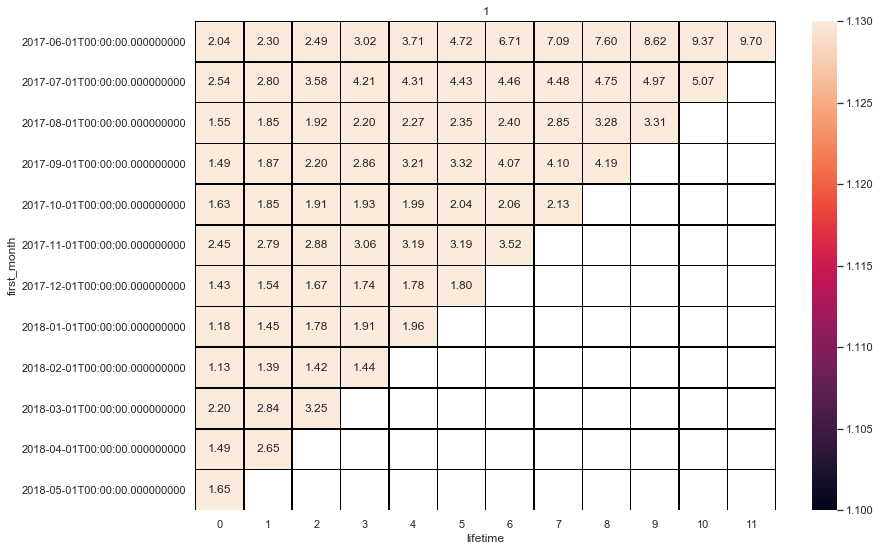

lifetime
0     0.758333
1     0.903636
2     1.066000
3     1.592222
4     1.822500
5     2.092857
6     2.226667
7     2.552000
8     2.940000
9     1.806667
10    2.365000
11    3.460000
dtype: float64


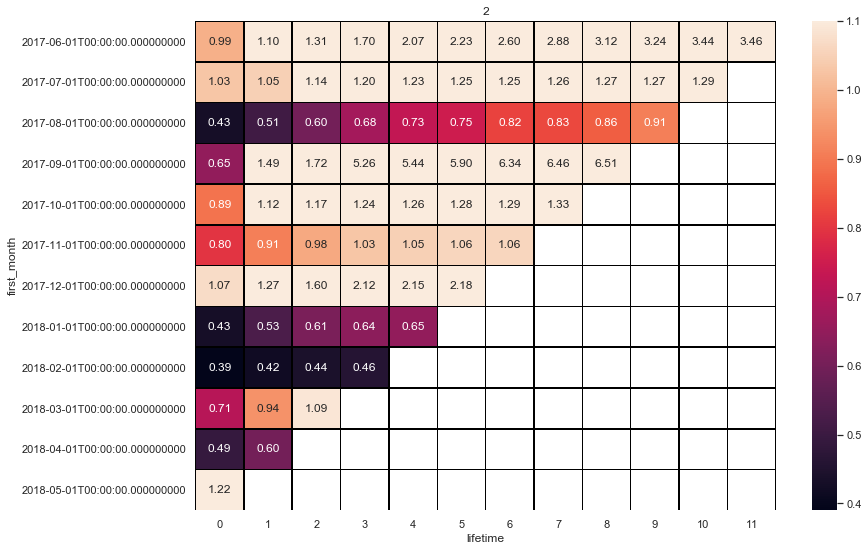

lifetime
0     0.271667
1     0.277273
2     0.292000
3     0.303333
4     0.312500
5     0.331429
6     0.343333
7     0.346000
8     0.365000
9     0.350000
10    0.385000
11    0.370000
dtype: float64


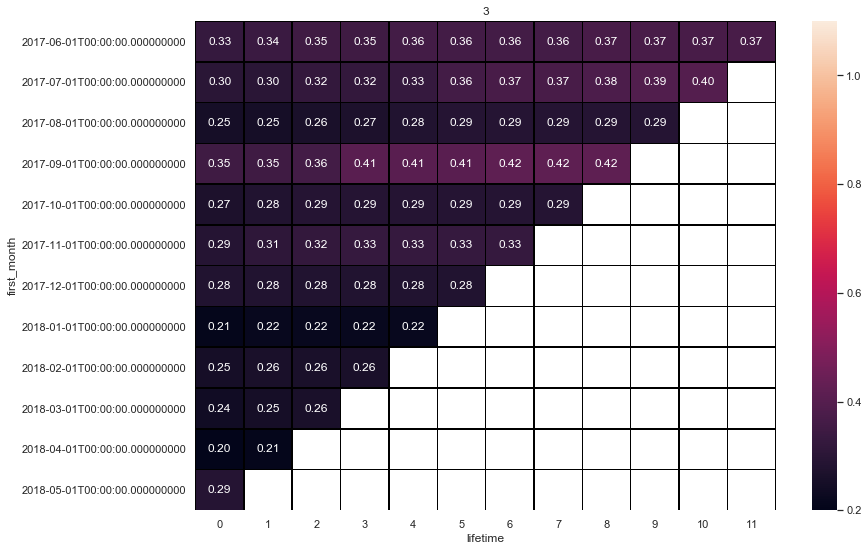

lifetime
0     0.689167
1     0.716364
2     0.732000
3     0.746667
4     0.775000
5     0.800000
6     0.831667
7     0.778000
8     0.757500
9     0.810000
10    0.910000
11    0.900000
dtype: float64


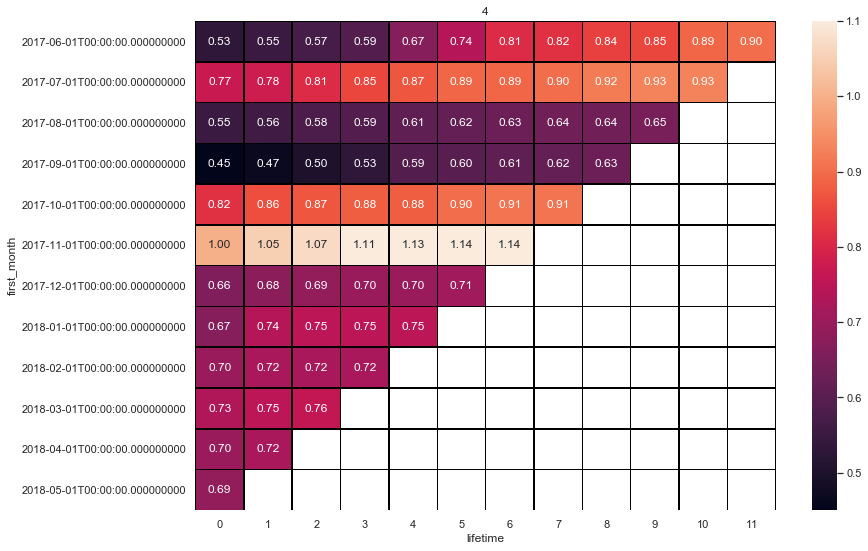

lifetime
0     0.879167
1     0.954545
2     1.017000
3     1.130000
4     1.245000
5     1.357143
6     1.465000
7     1.646000
8     1.830000
9     1.690000
10    1.710000
11    2.420000
dtype: float64


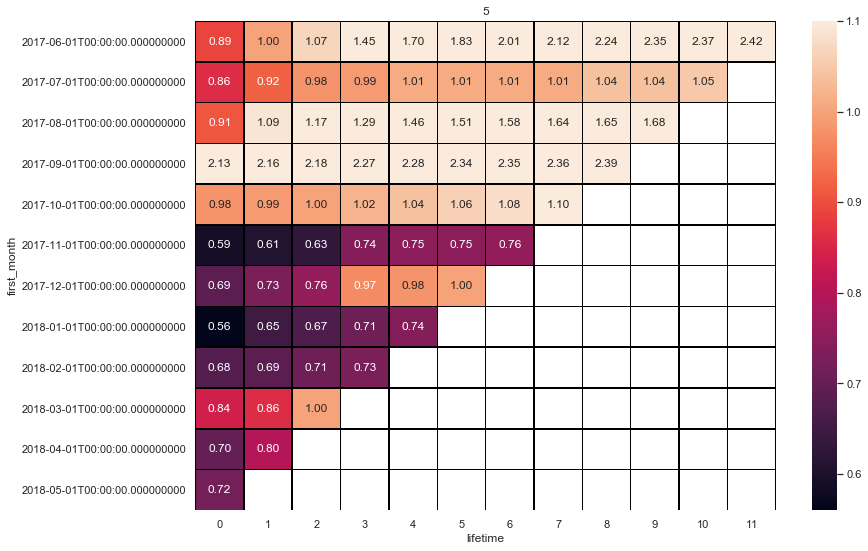

lifetime
0     0.551667
1     0.603000
2     0.670000
3     0.675000
4     0.704286
5     0.788333
6     0.825000
7     0.904000
8     1.066667
9     1.100000
10    1.320000
dtype: float64


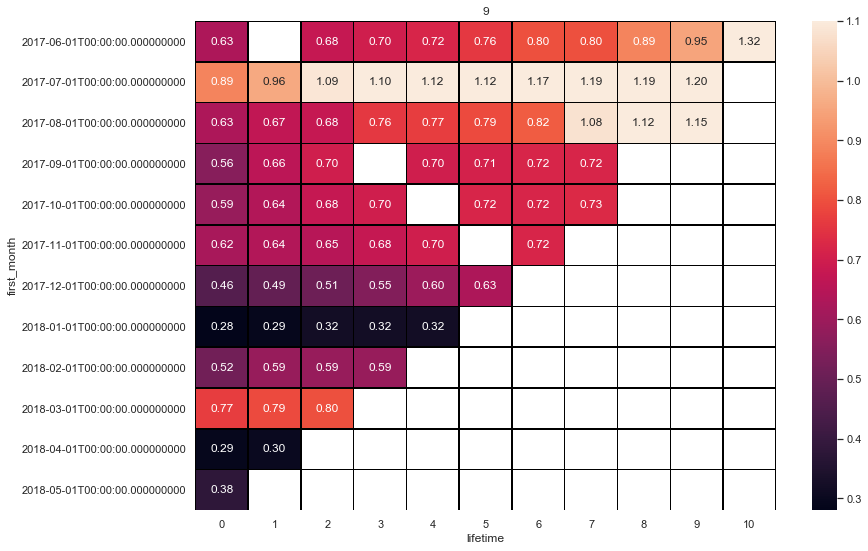

lifetime
0     0.759167
1     0.812222
2     0.696000
3     0.690000
4     0.686667
5     0.646667
6     0.550000
7     0.425000
8     0.620000
11    0.870000
dtype: float64


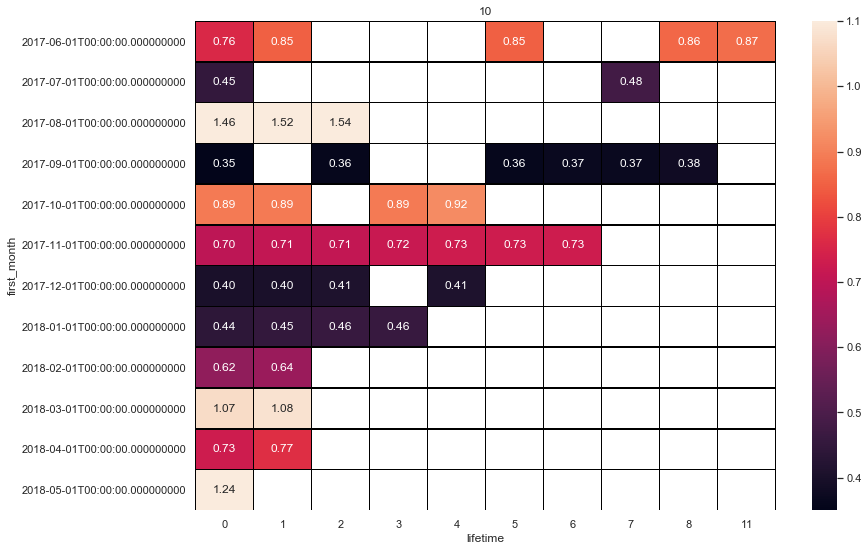

In [96]:
list_source = report_source['source_id'].unique().tolist()

for el in list_source:
    romi_n = report_source[report_source['source_id'] == el]
    romi_pivot = romi_n.pivot_table(
        index='first_month', columns='lifetime', values='romi', aggfunc='mean').round(2)
    romi_pivot = romi_pivot.cumsum(axis=1).round(2)
    print(romi_pivot.mean(axis=0))                # отображение среднего ROMI по источнику для средней когорты
    plt.figure(figsize=(13,9)) 
    sns.heatmap(
        romi_pivot, annot=True, fmt='.2f', vmax=1.1, linecolor='black', linewidths=0.5
    ).set_title(el)
    plt.show()                                    # отображение heatmap по когортам и lifetime по источнику

__1 источник__: по средней когорте окупаемость на 1 месяце. По всем когортам окупаемость в 1 мес, высокие значения, максимальное - 9.7. Самые низкие стартовые (за 0 мес) значения ROMI  - январь, февраль.  
__2 источник__: по средней когорте окупаемость на 3 месяце. Если смотреть по всем когортам, часть когорт действительно окупается за 1-3 месяц, но есть когорты, которые не окупились за рассматриваемое время(например, август, за 10 мес не окупились). Низкие стартовые (за 0 мес) значения ROMI  - август, январь, февраль, апрель.  
__3 источник__: по средней когорте не окупились. По всем когортам, тенденции на увеличение ROMI очень слабая, максимальное значение окупаемости - 0.4.  
__4 источник__: по средней когорте не окупились. Если смотреть по всем когортам, то окупилась только одна когорта - ноябрьская, в 1 месяц, при чем за 6 мес с 1.0 значение поднялось лишь до 1.14.  
__5 источник__: по средней когорте окупаемость на 3 месяце. Если смотреть по всем когортам, по которым есть данные за 6 мес и больше (июнь-декабрь), все когорты окупаются за 1-6 мес, но ноябрьская когорта за 7 мес не окупилась. Низкие стартовые (за 0 мес) значения ROMI  - ноябрь, январь.  
__9 источник__: по средней когорте окупаемость на 9 месяце. Если смотреть по всем когортам, по которым есть данные за 6 мес и больше (июнь-декабрь), окупились только три когорты - за 3, за 11 мес.  
__10 источник__: по средней когорте не окупились. Данные по многим месяцам отсутствуют.



### 3. Общий вывод

__Приоритет следует отдавать desktop устройствам.__  

Согласно DAU, WAU и MAU примерно в 2,5 раза чаще пользователи выбирают desktop устройства, соответсвенно и количество сессий с desktop больше (в 2,7 раз).  
Средняя длительность сессий на устройствах различна: desktop - 360 сек., touch - 180 сек.  
В среднем пользователь desktop заказывает чаще. 

В зимние месяцы показатель Retention Rate падает во всех когортах и продолжает снижение и весной. Следует рассмотреть вариант сезонности. Просадка по метрике наблюдалась и в августе, возможно, многие уезжали в отпуск, потому что количество покупателей заметно снизилось именно в это время. Пользователи, использующие touch, возвращаются реже, чем пользователи, использующие desktop. Показатели LTV на desktop тоже выше, чем на touch.

__Вкладываться следует в 1, 2 и 5 источник трафика.__  

1,2 и 5 источник имеют самый высокий LTV.  
3 источник, в который вкладывалось больше всего средств, менее эффективный. На него уходит больше средств на привлечение одного покупателя.  
По ROMI 3, 4 источники не окупаются. По 1 источнику самые высокие значения, окупаемость за 1 мес. По 2 источнику окупаемость большинства когорт - 2-3 месяца. По 5 - 1-4 месяца.  